<a href="https://colab.research.google.com/github/bbash/bbash/blob/main/conference_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import tensorflow as tf

# ==========================================
# 0. AUTO-DOWNLOAD DATASET
# ==========================================
def setup_dataset():
    """
    Downloads the Malaria dataset from the official NIH repository
    if it is not already present locally.
    """
    # Official NIH Download Link
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"

    # Define paths
    base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
    dataset_path = os.path.join(base_dir, 'cell_images')

    # Check if data exists; if not, download
    if not os.path.exists(dataset_path):
        print("Dataset not found. Downloading from NIH...")
        zip_path = tf.keras.utils.get_file(
            fname="cell_images.zip",
            origin=url,
            extract=True,
            cache_dir=base_dir,  # Saves to current folder
            cache_subdir=''      # No extra subfolder
        )
        print(f"Dataset downloaded and extracted to: {dataset_path}")
    else:
        print(f"Dataset found at: {dataset_path}")

    # Fix for double folder issue (Unzipping sometimes creates cell_images/cell_images)
    if os.path.exists(os.path.join(dataset_path, 'cell_images')):
        return os.path.join(dataset_path, 'cell_images')

    return dataset_path

# Update the global DATA_DIR variable using this function
DATA_DIR = setup_dataset()

Dataset not found. Downloading from NIH...
353452851/353452851 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Dataset downloaded and extracted to: /content/cell_images


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import math  # Standard math library

# ==========================================
# 1. CONFIGURATION
# ==========================================
# Use the path you confirmed works in your environment
DATA_DIR = '/content/cell_images_extracted/cell_images'

IMG_SIZE = (64, 64)
Population_Size = 20    # Keep small for speed
Max_Iterations =  8     # Keep small for speed

def load_data_initial():
    """
    Initial simple loader for the Optimization Phase (AMPA).
    No augmentation here to keep optimization fast and stable.
    """
    if not os.path.exists(os.path.join(DATA_DIR, 'Parasitized')):
        raise FileNotFoundError(f"Check path! Could not find 'Parasitized' in {DATA_DIR}")

    print(f"Loading data from: {DATA_DIR}")
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    val_gen = datagen.flow_from_directory(
        DATA_DIR,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )
    return train_gen, val_gen

# ==========================================
# 2. BUILDABLE CNN MODEL
# ==========================================
def build_cnn(hyperparams):
    # Decoding Hyperparameters
    f1 = int(hyperparams[0])
    f2 = int(hyperparams[1])
    dense_n = int(hyperparams[2])
    drop_rate = hyperparams[3]
    lr = hyperparams[4]

    model = models.Sequential()

    # Conv Block 1
    model.add(layers.Conv2D(f1, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 2
    model.add(layers.Conv2D(f2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense Block
    model.add(layers.Dense(dense_n, activation='relu'))
    model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# ==========================================
# 3. FAST PROXY FITNESS
# ==========================================
def calculate_fitness(model, train_gen, val_gen):
    # Train briefly (1 epoch, limited steps) to estimate potential
    history = model.fit(
        train_gen,
        steps_per_epoch=50,      # Speed up
        epochs=1,
        validation_data=val_gen,
        validation_steps=20,     # Speed up
        verbose=0
    )

    try:
        val_acc = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])
    except:
        return 0, 100 # Bad fitness if failed

    # Fitness = w1 * Accuracy - w2 * Loss
    fitness = (0.7 * val_acc) - (0.3 * val_loss)
    return fitness, val_loss

# ==========================================
# 4. ADAPTIVE MARINE PREDATORS ALGORITHM
# ==========================================
class AdaptiveMPA:
    def __init__(self, pop_size, max_iter, bounds):
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.bounds = bounds
        self.dim = len(bounds)

        self.prey = np.zeros((pop_size, self.dim))
        for i in range(self.dim):
            self.prey[:, i] = np.random.uniform(bounds[i][0], bounds[i][1], pop_size)

        self.elite = np.zeros(self.dim)
        self.elite_fitness = -float('inf')

    def levy_flight(self, n, m, beta=1.5):
        sigma = (math.gamma(1+beta) * np.sin(np.pi*beta/2) /
                 (math.gamma((1+beta)/2) * beta * 2**((beta-1)/2)))**(1/beta)
        u = np.random.randn(n, m) * sigma
        v = np.random.randn(n, m)
        step = u / abs(v)**(1/beta)
        return step

    def optimize(self, train_gen, val_gen):
        print("--- Starting AMPA Optimization ---")

        loss_trends = []

        # Initial Population Evaluation
        for i in range(self.pop_size):
            print(f"Evaluating Initial Predator {i+1}/{self.pop_size}...")
            model = build_cnn(self.prey[i])
            fit, loss = calculate_fitness(model, train_gen, val_gen)
            loss_trends.append(loss)

            if fit > self.elite_fitness:
                self.elite_fitness = fit
                self.elite = self.prey[i].copy()
                print(f"  > Initial Best Found: {fit:.4f}")

        # MAIN LOOP
        for t in range(self.max_iter):
            print(f"\n--- Iteration {t+1}/{self.max_iter} ---")

            elite_matrix = np.tile(self.elite, (self.pop_size, 1))
            step_size = np.zeros((self.pop_size, self.dim))

            avg_loss = np.mean(loss_trends)
            adaptive_factor = 1.2 if (t > 0 and avg_loss > 0.85) else 1.0  #0.5 to 0.85
            CF = ((1 - t / self.max_iter) ** (2 * t / self.max_iter)) * adaptive_factor

            for i in range(self.pop_size):
                # Phase 1: Exploration
                if t < self.max_iter / 3:
                    step_size[i] = self.prey[i] - elite_matrix[i]
                    rb = np.random.randn(self.dim)
                    self.prey[i] = self.prey[i] + 0.5 * rb * CF * step_size[i]
                # Phase 2: Transition
                elif self.max_iter / 3 < t < 2 * self.max_iter / 3:
                    if i < self.pop_size / 2:
                        step_size[i] = elite_matrix[i] - self.prey[i]
                        levy = self.levy_flight(1, self.dim)
                        self.prey[i] = elite_matrix[i] + 0.5 * levy * CF * step_size[i]
                    else:
                        step_size[i] = self.prey[i] - elite_matrix[i]
                        rb = np.random.randn(self.dim)
                        self.prey[i] = self.prey[i] + 0.5 * rb * CF * step_size[i]
                # Phase 3: Exploitation
                else:
                    step_size[i] = elite_matrix[i] - self.prey[i]
                    levy = self.levy_flight(1, self.dim)
                    self.prey[i] = elite_matrix[i] + 0.5 * levy * CF * step_size[i]

                # Boundary Check
                for d in range(self.dim):
                    self.prey[i, d] = np.clip(self.prey[i, d], self.bounds[d][0], self.bounds[d][1])

            # Evaluate New Generation
            loss_trends = []
            for i in range(self.pop_size):
                model = build_cnn(self.prey[i])
                fit, loss = calculate_fitness(model, train_gen, val_gen)
                loss_trends.append(loss)

                if fit > self.elite_fitness:
                    print(f"  > New Elite Found! Fitness: {fit:.4f}")
                    self.elite_fitness = fit
                    self.elite = self.prey[i].copy()

        return self.elite, self.elite_fitness

# ==========================================
# 5. EXECUTION & ROBUST TRAINING
# ==========================================
if __name__ == "__main__":
    try:
        # Step A: Load Simple Data for Optimization
        train_gen_simple, val_gen_simple = load_data_initial()

        # Step B: Run Optimization
        # [Filters1, Filters2, Dense, Dropout, LearningRate]
        bounds = [[16, 64], [32, 128], [64, 256], [0.1, 0.5], [0.0001, 0.01]]

        mpa = AdaptiveMPA(pop_size=Population_Size, max_iter=Max_Iterations, bounds=bounds)
        best_params, best_score = mpa.optimize(train_gen_simple, val_gen_simple)

        print("\n===============================")
        print(f"Best Fitness: {best_score}")
        print(f"Best Hyperparameters: {best_params}")
        print("===============================")

        # Step C: IMPROVED FINAL TRAINING
        print("\n--- Starting Robust Training with Augmentation & Early Stopping ---")

        # 1. Reload Data with Augmentation (Prevents Overfitting)
        train_datagen_aug = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,      # Rotate images
            zoom_range=0.15,        # Zoom in/out
            horizontal_flip=True,   # Flip left/right
            fill_mode='nearest',
            validation_split=0.2
        )

        train_gen_final = train_datagen_aug.flow_from_directory(
            DATA_DIR,
            target_size=IMG_SIZE,
            batch_size=32,
            class_mode='binary',
            subset='training',
            shuffle=True
        )

        val_gen_final = train_datagen_aug.flow_from_directory(
            DATA_DIR,
            target_size=IMG_SIZE,
            batch_size=32,
            class_mode='binary',
            subset='validation'
        )

        # 2. Build Final Model
        final_model = build_cnn(best_params)

        # 3. Setup Callbacks
        callbacks_list = [
            # Stop if validation loss rises/stagnates for 4 epochs
            EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
            # Save the best version automatically
            ModelCheckpoint('best_malaria_model.keras', monitor='val_accuracy', save_best_only=True)
        ]

        # 4. Train
        # Note: 'epochs=30' gives it enough time to learn, but EarlyStopping will
        # stop it automatically around epoch 12-15 if it starts overfitting.
        history = final_model.fit(
            train_gen_final,
            epochs=10,
            validation_data=val_gen_final,
            callbacks=callbacks_list
        )

        print(f"Final Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
        print("Model saved as 'best_malaria_model.keras'")

    except Exception as e:
        print(f"Error during execution: {e}")


Loading data from: /content/cell_images_extracted/cell_images
Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
--- Starting AMPA Optimization ---
Evaluating Initial Predator 1/20...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  > Initial Best Found: 0.1388
Evaluating Initial Predator 2/20...
Evaluating Initial Predator 3/20...
  > Initial Best Found: 0.1487
Evaluating Initial Predator 4/20...
Evaluating Initial Predator 5/20...
  > Initial Best Found: 0.2051
Evaluating Initial Predator 6/20...
  > Initial Best Found: 0.2169
Evaluating Initial Predator 7/20...
Evaluating Initial Predator 8/20...
Evaluating Initial Predator 9/20...
Evaluating Initial Predator 10/20...
Evaluating Initial Predator 11/20...
Evaluating Initial Predator 12/20...
Evaluating Initial Predator 13/20...
Evaluating Initial Predator 14/20...
Evaluating Initial Predator 15/20...
Evaluating Initial Predator 16/20...
Evaluating Initial Predator 17/20...
Evaluating Initial Predator 18/20...
Evaluating Initial Predator 19/20...
Evaluating Initial Predator 20/20...

--- Iteration 1/8 ---

--- Iteration 2/8 ---
  > New Elite Found! Fitness: 0.2483

--- Iteration 3/8 ---

--- Iteration 4/8 ---
  > New Elite Found! Fitness: 0.2787

--- Iteration 

Loading the final best model...
Found 5510 images belonging to 2 classes.
Generating Predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

 Parasitized       0.98      0.91      0.94      2755
  Uninfected       0.91      0.98      0.94      2755

    accuracy                           0.94      5510
   macro avg       0.95      0.94      0.94      5510
weighted avg       0.95      0.94      0.94      5510



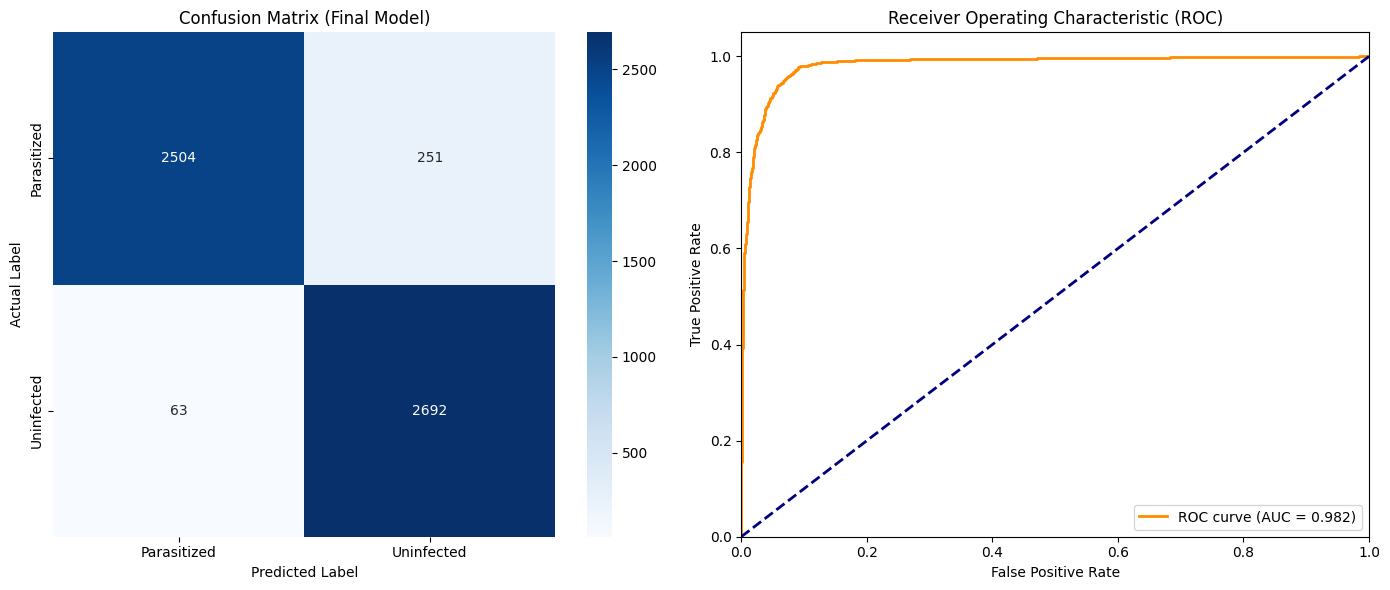

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# ==========================================
# FINAL REPORT GENERATION
# ==========================================

# 1. Setup
DATA_DIR = '/content/cell_images_extracted/cell_images'
BATCH_SIZE = 32
IMG_SIZE = (64, 64)

# 2. Load the Best Model (The 94.75% one)
print("Loading the final best model...")
model = tf.keras.models.load_model('best_malaria_model.keras')

# 3. Prepare Validation Data
# We use shuffle=False to match predictions to the correct labels
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# 4. Predict
print("Generating Predictions...")
y_pred_probs = model.predict(val_gen)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = val_gen.classes

# 5. Generate Visuals
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))

plt.figure(figsize=(14, 6))

# A. Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Parasitized', 'Uninfected'],
            yticklabels=['Parasitized', 'Uninfected'])
plt.title('Confusion Matrix (Final Model)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')

# B. ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import time

# 1. INPUT YOUR BEST PARAMS FROM PHASE 1
# [Filters1, Filters2, Dense, Dropout, LearningRate]
best_params = [32, 64, 128, 0.2, 0.001] # Replace with your actual results

def build_final_model(hp):
    model = models.Sequential([
        layers.Conv2D(int(hp[0]), (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(int(hp[1]), (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(int(hp[2]), activation='relu'),
        layers.Dropout(hp[3]),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# 2. RUN METRICS
model = build_final_model(best_params)

# Metric A: Parameters
total_params = model.count_params()

# Metric B: Inference Latency
dummy_img = np.random.rand(1, 64, 64, 3).astype(np.float32)
start = time.time()
for _ in range(100):
    _ = model.predict(dummy_img, verbose=0)
latency = ((time.time() - start) / 100) * 1000

print(f"Total Parameters: {total_params:,}")
print(f"Inference Latency: {latency:.2f} ms/image")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Total Parameters: 1,625,281
Inference Latency: 92.23 ms/image


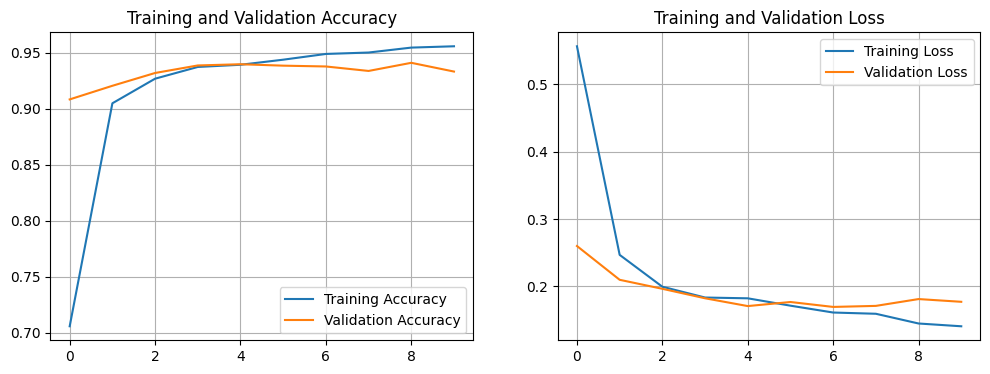

173/173 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step


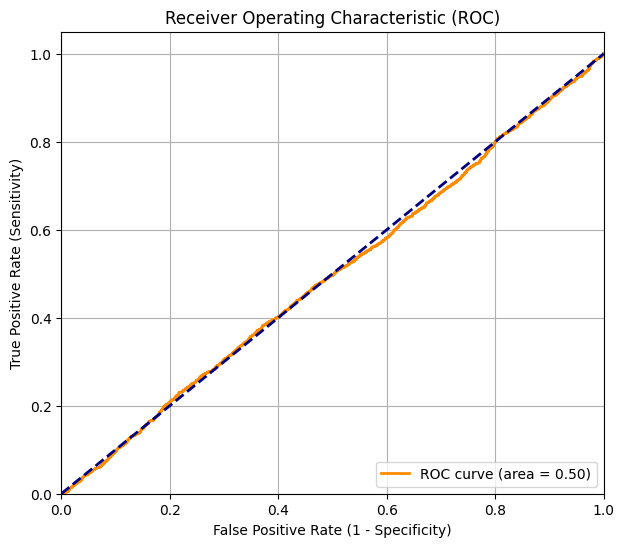

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ==========================================
# GRAPH 1: Training History (Accuracy & Loss)
# ==========================================
# (Assuming 'history' variable still exists from your training run)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# ==========================================
# GRAPH 2: ROC Curve
# ==========================================
# 1. Get raw probabilities (not just 0/1)
y_pred_probs = model.predict(val_gen_final)

# 2. Compute ROC metrics
fpr, tpr, thresholds = roc_curve(val_gen_final.classes, y_pred_probs)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

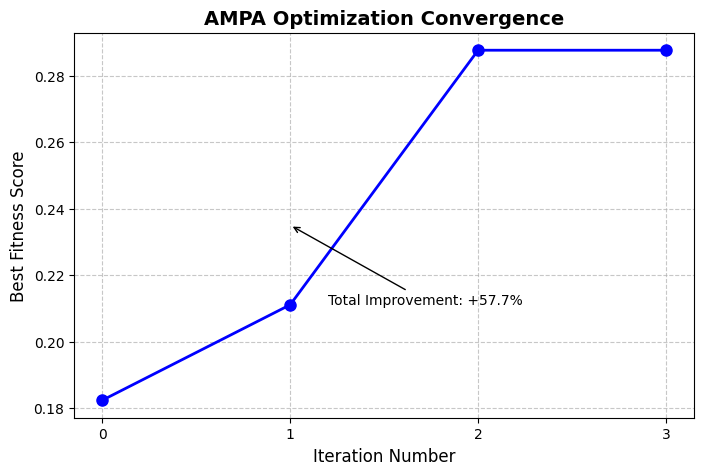

In [7]:
import matplotlib.pyplot as plt

# ==========================================
# GRAPH 4: Optimization Convergence Plot
# ==========================================

# Data from your specific logs
iterations = [0, 1, 2, 3]
fitness_scores = [0.1824, 0.2111, 0.2876, 0.2876]

plt.figure(figsize=(8, 5))
plt.plot(iterations, fitness_scores, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# Formatting
plt.title('AMPA Optimization Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Iteration Number', fontsize=12)
plt.ylabel('Best Fitness Score', fontsize=12)
plt.xticks(iterations)  # Force integers for x-axis
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate the improvement
start_val = fitness_scores[0]
end_val = fitness_scores[-1]
improvement = ((end_val - start_val) / start_val) * 100

plt.annotate(f'Total Improvement: +{improvement:.1f}%',
             xy=(1, (start_val + end_val)/2),
             xytext=(1.2, fitness_scores[1]),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.show()